In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [14]:
# Definir una transformación para normalizar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [15]:
# Descargar y cargar el conjunto de datos CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./CIFAR', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./CIFAR', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# Definir las clases
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [17]:
# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Aplicar corrupción a las imágenes
def corrupt_images(images, corruption_level):
    corrupted_images = images.clone()
    num_pixels = int(corruption_level / 100 * images.numel())
    indices = torch.randperm(images.numel())[:num_pixels]
    corrupted_images.view(-1)[indices] = torch.randint_like(corrupted_images.view(-1)[indices], low=0, high=256) / 255
    return corrupted_images

# Definir el modelo
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionNet(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [18]:
net = InceptionNet()

# Definir el criterio de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [19]:
# Función para entrenar el modelo
def train_model(corruption_level, epochs):
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Entrenamiento
        net.train()
        for data in trainloader:
            inputs, labels = data
            inputs = corrupt_images(inputs, corruption_level)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total

        # Validación
        net.eval()
        correct = 0
        total = 0
        val_loss = 0.0

        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                inputs = corrupt_images(inputs, corruption_level)

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = val_loss / len(testloader)
        valid_acc = 100 * correct / total

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Acc: {train_acc:.2f}%, Valid Acc: {valid_acc:.2f}%')

    return train_losses, valid_losses, train_accs, valid_accs

In [20]:
# Definir las épocas y los niveles de corrupción
epochs = 100
corruption_levels = [0, 20, 40, 60, 80, 100]

In [21]:
# Diccionario para almacenar los resultados
results = {}


Entrenando con 0% de corrupción:


Imágenes con 0% de corrupción:


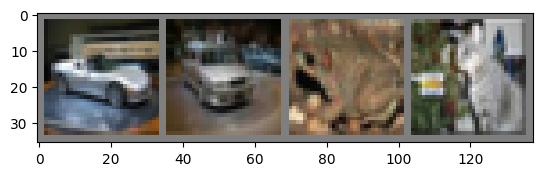

KeyboardInterrupt: 

In [22]:
# Entrenar el modelo para cada nivel de corrupción y mostrar ejemplos de imágenes
for level in corruption_levels:
    print(f'\nEntrenando con {level}% de corrupción:')

    # Mostrar ejemplos de imágenes
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    corrupted_images = corrupt_images(images, level)

    print(f'Imágenes con {level}% de corrupción:')
    imshow(torchvision.utils.make_grid(corrupted_images[:4]))

    train_losses, valid_losses, train_accs, valid_accs = train_model(level, epochs)
    results[level] = {
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_accs': train_accs,
        'valid_accs': valid_accs
    }


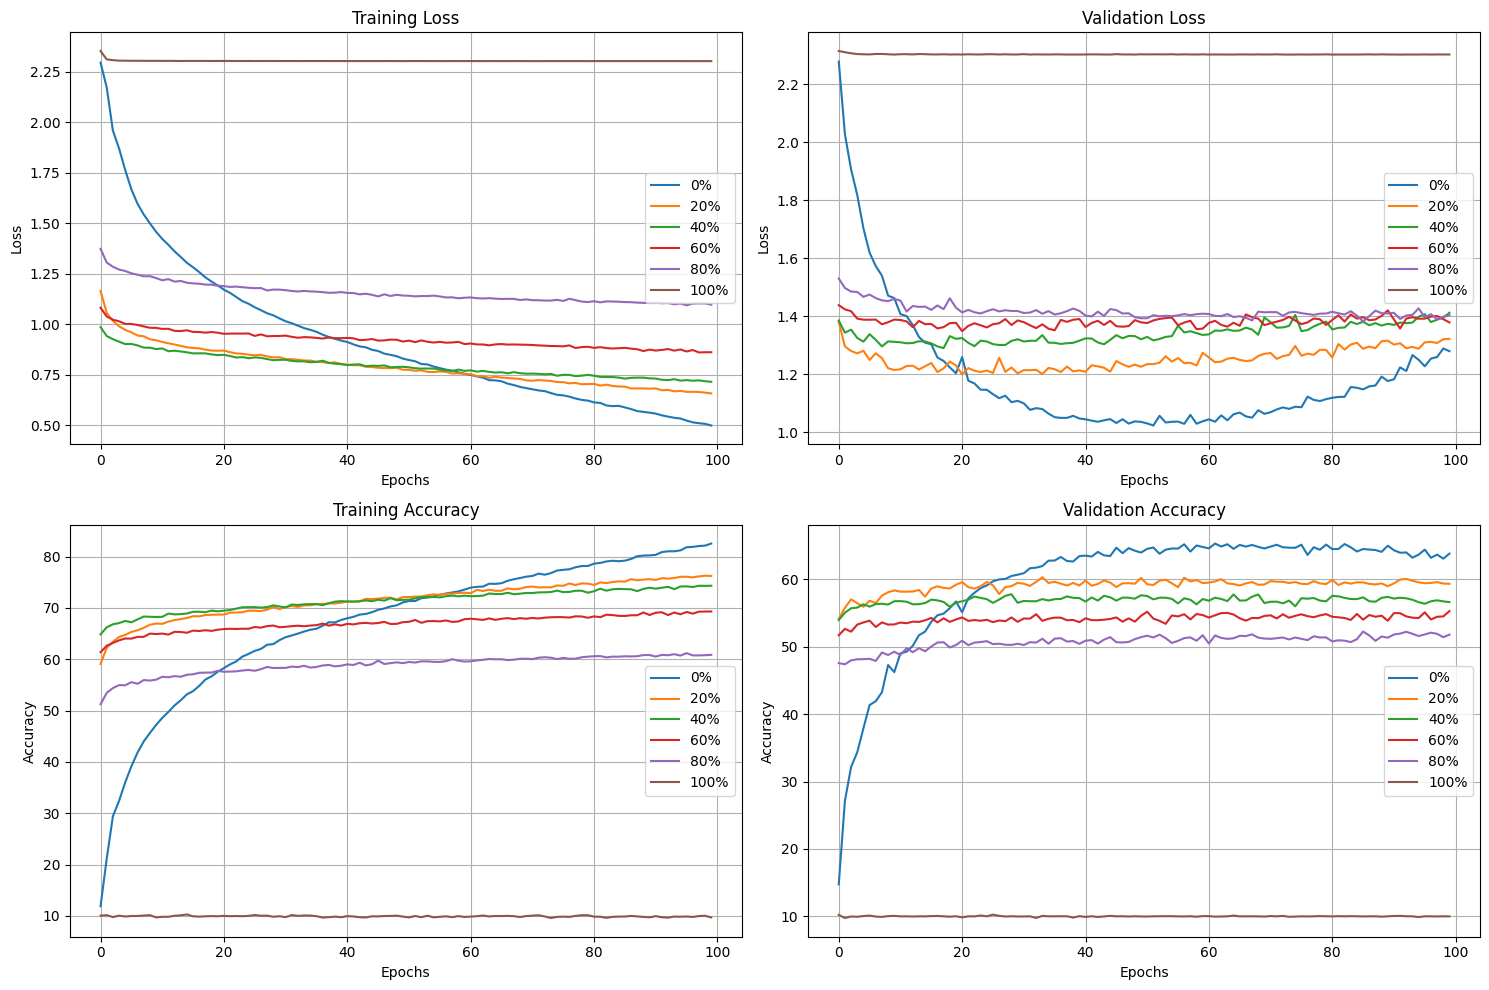

In [ ]:
# Graficar los resultados comparativos
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for level in corruption_levels:
    axs[0, 0].plot(results[level]['train_losses'], label=f'{level}%')
axs[0, 0].set_title('Training Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Validation Loss
for level in corruption_levels:
    axs[0, 1].plot(results[level]['valid_losses'], label=f'{level}%')
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Training Accuracy
for level in corruption_levels:
    axs[1, 0].plot(results[level]['train_accs'], label=f'{level}%')
axs[1, 0].set_title('Training Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Validation Accuracy
for level in corruption_levels:
    axs[1, 1].plot(results[level]['valid_accs'], label=f'{level}%')
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# Save results in a dictionary

In [ ]:
with open('final_input.pickle', 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)